<a href="https://colab.research.google.com/github/AdrianaLecourieux/Long_project/blob/main/Long__project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⏸ Long Project

In this notebooks, you'll find : 



0.   Preliminary steps
1.   Binary classification on shape data
2.   Binary classification on time projected data (3 times)
3.   Classification 3 classes
4.   Tests on cells from bone marrow film (tumor)
5.   Binary classification (0=low affinity, 1=medium+high afffinity)
6.   Binary classification with cells edges





# ⏬ 0. Preliminary steps 

## 0.1. Import modules and mount drive


Import modules

In [1]:
import pandas as pd       
import numpy as np
import os
import keras
import tensorflow as tf
import cv2 # to open images

# For data visualization
from matplotlib import pyplot as plt # data visualization

# For building models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# Plot model
from keras.utils.vis_utils import plot_model 

# For evaluating model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import classification_report

# For confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# For saving model
from tensorflow.keras.models import load_model

# For model interpretation
#import shap


Mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.2. Fonction definitions

### 0.2.1 Preprocessing

In [3]:
def get_train_test_validation_split(path, validation_split, seed, img_height, img_width, batch_size):
  '''
  Split dataset into train (70%), test (20%) and validation (10%) sets.

  Parameter
  _________

    path :
      path to the data.
    validation_split : int
      repartition of the data
    seed : int
      set seed
    img_height : int
      height of the image
    img_width : int
      width of the image
    batch_size : int
      size of the batch

  Return
  ______

    Train, test and validation sets.
  '''
  train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split= validation_split,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

  val_batches = tf.data.experimental.cardinality(val_ds)
  test_ds = val_ds.take((2*val_batches) // 3)
  val_ds = val_ds.skip((2*val_batches) // 3)

  return train_ds, test_ds, val_ds

In [4]:
def plot_train_images(train, class_names):
  '''
  Plot exemple of train dataset images.

  Parameter
  _________

    train :
      train set.
    class_names : 
      Name of the classes

  Return
  ______

    Plot of 9 images with legend.
  '''
  plt.figure(figsize=(10, 10))
  for images, labels in train.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

In [5]:
def normalize_dataset(train):
  normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
  image_batch, labels_batch = next(iter(normalized_ds))
  first_image = image_batch[0]
  return normalized_ds, image_batch, labels_batch, first_image

In [6]:
def cache(train, validation):
  AUTOTUNE = tf.data.AUTOTUNE
  train = train.cache().prefetch(buffer_size=AUTOTUNE)
  validation = validation.cache().prefetch(buffer_size=AUTOTUNE)
  return train, validation

### 0.2.3 Evaluate model

In [7]:
def accuracy_plot(fitting_history):
  '''
  Plots the accuracy against the number of epochs.

  Parameter
  _________

    fitting_history :
      The history of a model.fit.

  Return
  ______

    The accuracy plot.
  '''
  plt.plot(fitting_history.history['accuracy'])
  plt.plot(fitting_history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  
  return plt.show()

In [8]:
def loss_plot(fitting_history):
  '''
  Plots the loss against the number of epochs.

  Parameter
  _________

    fitting_history :
      The history of a model.fit.

  Return
  ______

    The loss plot.
  '''
  plt.plot(fitting_history.history['loss'])
  plt.plot(fitting_history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  
  return plt.show()

In [9]:
def get_evaluation_model(test, model):
  '''
  Evaluate precision, recall and accuracy of the model with test set.

  Parameter
  _________

    test :
      test set
    model :
      keras model

  Return
  ______

    Precision, recall and accuracy values.
  '''
  pre = Precision()
  re = Recall()
  acc = BinaryAccuracy()

  for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

  print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Binary classification

In [10]:
def confusion_matrix(test,model):
  '''
  Plots the predicted predictions against true values.

  Parameter
  _________

    test :
      test set
    model :
      keras model

  Return
  ______

    The confusion matrix.
  '''
  y_pred = []  # store predicted labels
  y_true = []  # store true labels
  # iterate over the dataset
  for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(preds.round())

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)
  
  return ConfusionMatrixDisplay.from_predictions(predicted_labels, correct_labels)


In [11]:
  def classif_report(test,model):
    '''
    .

    Parameter
    _________

      test :
        test set
      model :
        keras model

    Return
    ______

      The classification report.
    '''
    y_pred = []  # store predicted labels
    y_true = []  # store true labels
    # iterate over the dataset
    for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
      # append true labels
      y_true.append(label_batch)
      # compute predictions
      preds = model.predict(image_batch)
      # append predicted labels
      y_pred.append(preds.round())

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    
    print(classification_report(correct_labels, predicted_labels))


Classification 3 classes

In [12]:
def confusion_matrix_3_classses(test, model):
  y_pred = []  # store predicted labels
  y_true = []  # store true labels

  # iterate over the dataset
  for image_batch, label_batch in test_3:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model_3classes.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)

  return ConfusionMatrixDisplay.from_predictions(predicted_labels, correct_labels)

In [13]:
  def classif_report_3_classes(test, model):
    '''
    .

    Parameter
    _________

      test :
        test set
      model :
        keras model

    Return
    ______

      The classification report.
    '''
    y_pred = []  # store predicted labels
    y_true = []  # store true labels
    # iterate over the dataset
    for image_batch, label_batch in test:   # use dataset.unbatch() with repeat
      # append true labels
      y_true.append(label_batch)
      # compute predictions
      preds = model.predict(image_batch)
      # append predicted labels
      y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    
    print(classification_report(correct_labels, predicted_labels))


## 0.3. Variable definitions

### 0.3.1. Preprocessing

In [14]:
batch_size = 32
img_height = 100
img_width = 100
seed=123
validation_split = 0.3


In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


### 0.3.2. Preprocessing

# ⏬ Part 1 : Binary classification on shape data 

## 1.1. Preprocessing

In [ ]:
data_dir_1 = "/content/drive/MyDrive/long_project/shape_data"

In [ ]:
train, test, validation = get_train_test_validation_split(data_dir_1, validation_split, seed, img_height, img_width, batch_size)

Found 2571 files belonging to 2 classes.
Using 1800 files for training.
Found 2571 files belonging to 2 classes.
Using 771 files for validation.


In [ ]:
class_names = train.class_names
print(class_names)

['non_specific_cells', 'specific_cells']


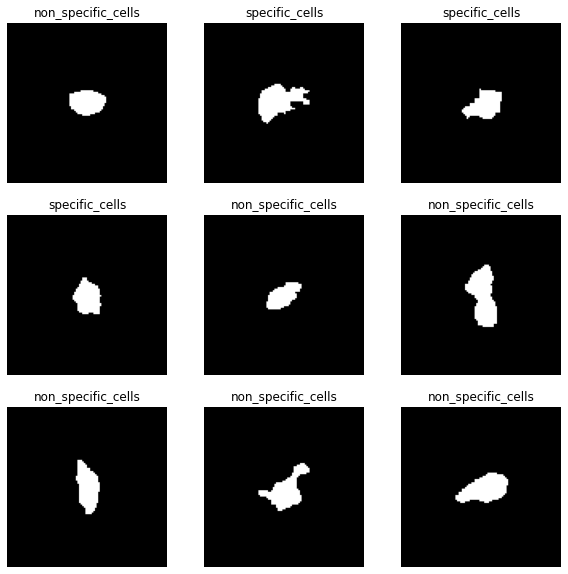

In [ ]:
plot_train_images(train, class_names)

In [ ]:
normalized_ds, image_batch, labels_batch, first_image = normalize_dataset(train)
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
train, validation = cache(train, validation)

## 1.2 Model

In [ ]:
num_classes = 2
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(
  train,
  validation_data=validation,
  epochs=15
)

Epoch 1/15
57/57 [==============================] - 55s 955ms/step - loss: 0.6605 - accuracy: 0.6100 - val_loss: 0.6276 - val_accuracy: 0.6602
Epoch 2/15
57/57 [==============================] - 9s 158ms/step - loss: 0.6142 - accuracy: 0.6822 - val_loss: 0.5952 - val_accuracy: 0.6911
Epoch 3/15
57/57 [==============================] - 9s 156ms/step - loss: 0.5794 - accuracy: 0.7106 - val_loss: 0.5671 - val_accuracy: 0.7529
Epoch 4/15
57/57 [==============================] - 9s 162ms/step - loss: 0.5255 - accuracy: 0.7467 - val_loss: 0.5044 - val_accuracy: 0.7645
Epoch 5/15
57/57 [==============================] - 12s 209ms/step - loss: 0.4604 - accuracy: 0.7950 - val_loss: 0.4253 - val_accuracy: 0.8224
Epoch 6/15
57/57 [==============================] - 12s 209ms/step - loss: 0.3622 - accuracy: 0.8450 - val_loss: 0.3733 - val_accuracy: 0.8494
Epoch 7/15
57/57 [==============================] - 10s 171ms/step - loss: 0.3060 - accuracy: 0.8678 - val_loss: 0.3140 - val_accuracy: 0.8649
Ep

## 1.3 Evaluate model

### 1.3.1 Plot performance

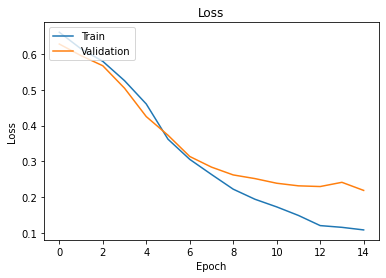

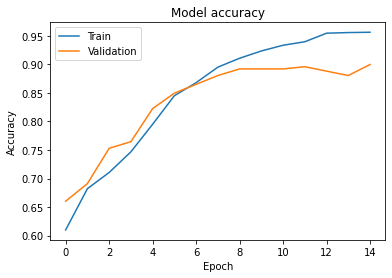

In [ ]:
loss_plot(history)
print("")
accuracy_plot(history)

### 1.3.2 Evaluate

In [ ]:
get_evaluation_model(test, model)

1/1 [==============================] - 0s 91ms/step
Precision: 0.8399999737739563, Recall: 0.9210526347160339, Accuracy: 0.88671875


### 1.3.3 Confusion matrix

1/1 [==============================] - 0s 83ms/step


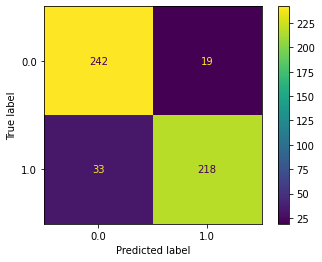

In [ ]:
confusion_matrix(test, model)

In [ ]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       284
           1       0.86      0.93      0.89       228

    accuracy                           0.90       512
   macro avg       0.90      0.91      0.90       512
weighted avg       0.91      0.90      0.90       512



## 1.4 Save the model

In [ ]:
model.save('../content/drive/MyDrive/long_project/saved_models/shape_model')

In [33]:
model3_classes = load_model("../content/drive/MyDrive/long_project/saved_models/3_classes_model")

In [34]:
print(f'{model3_classes.summary()}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 16)        4624      
                                                                 
 dropout_1 (Dropout)         (None, 21, 21, 16)       

# ⏬ Part 2 : Binary classification on time projected data (3 times)

## 2.1 Preprocessing

In [16]:
data_dir_2 = "../content/drive/MyDrive/long_project/Z_projection_data"

In [17]:
train_2, test_2, validation_2 = get_train_test_validation_split(data_dir_2, validation_split, seed, img_height, img_width, batch_size)

Found 3366 files belonging to 2 classes.
Using 2357 files for training.
Found 3366 files belonging to 2 classes.
Using 1009 files for validation.


In [18]:
class_names_2= train_2.class_names
print(class_names_2)

['non_specific_cells_time_projected', 'specific_cells_time_projected']


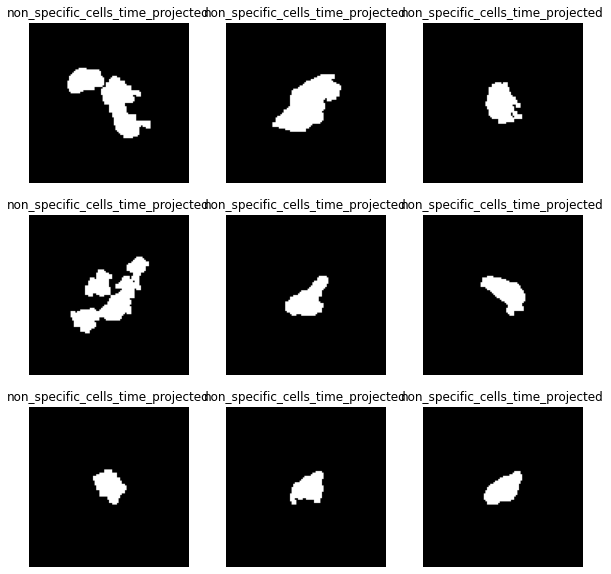

In [19]:
plot_train_images(train_2, class_names_2)

In [20]:
normalized_ds, image_batch, labels_batch, first_image = normalize_dataset(train_2)

In [21]:
train_2, validation_2 = cache(train_2, validation_2)

## 2.2. Build model

In [22]:
logdir='logs' 

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [24]:
model_time_projection_2_classes = Sequential()  

model_time_projection_2_classes.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_time_projection_2_classes.add(MaxPooling2D())
model_time_projection_2_classes.add(Conv2D(32, (3,3), 1, activation='relu'))
model_time_projection_2_classes.add(MaxPooling2D())
model_time_projection_2_classes.add(Conv2D(16, (3,3), 1, activation='relu'))
model_time_projection_2_classes.add(Dropout(0.2))
model_time_projection_2_classes.add(MaxPooling2D())
model_time_projection_2_classes.add(Flatten())
model_time_projection_2_classes.add(Dense(100, activation='relu'))
model_time_projection_2_classes.add(Dense(1, activation='sigmoid'))

model_time_projection_2_classes.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
hist_time_projection = model_time_projection_2_classes.fit(train_2, epochs=19, validation_data=validation_2, callbacks=[tensorboard_callback])

Epoch 1/19
74/74 [==============================] - 188s 3s/step - loss: 3.4822 - accuracy: 0.6245 - val_loss: 0.6879 - val_accuracy: 0.6944
Epoch 2/19
74/74 [==============================] - 19s 259ms/step - loss: 0.5549 - accuracy: 0.7454 - val_loss: 0.5077 - val_accuracy: 0.7745
Epoch 3/19
74/74 [==============================] - 19s 258ms/step - loss: 0.4119 - accuracy: 0.8129 - val_loss: 0.4508 - val_accuracy: 0.8131
Epoch 4/19
74/74 [==============================] - 21s 284ms/step - loss: 0.3144 - accuracy: 0.8600 - val_loss: 0.4095 - val_accuracy: 0.8457
Epoch 5/19
74/74 [==============================] - 20s 268ms/step - loss: 0.2375 - accuracy: 0.8986 - val_loss: 0.5064 - val_accuracy: 0.7893
Epoch 6/19
74/74 [==============================] - 20s 267ms/step - loss: 0.1799 - accuracy: 0.9224 - val_loss: 0.2925 - val_accuracy: 0.8991
Epoch 7/19
74/74 [==============================] - 20s 271ms/step - loss: 0.1169 - accuracy: 0.9550 - val_loss: 0.2681 - val_accuracy: 0.9169
E

## 2.3. Evaluate

### 2.3.1 Plot performance

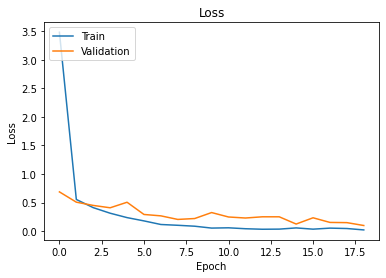

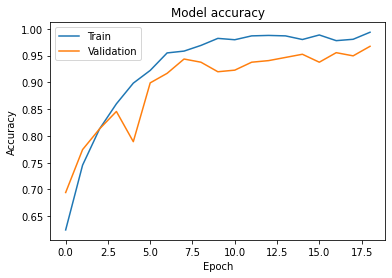

In [26]:
loss_plot(hist_time_projection)
print("")
accuracy_plot(hist_time_projection)

### 2.3.2 Evaluate

In [27]:
get_evaluation_model(test_2, model_time_projection_2_classes)

1/1 [==============================] - 0s 90ms/step
Precision: 0.9714285731315613, Recall: 0.9622641801834106, Accuracy: 0.96875


### 2.3.3 Confusion matrix

1/1 [==============================] - 0s 112ms/step


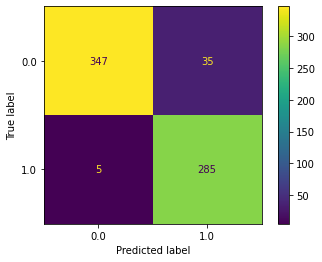

In [ ]:
confusion_matrix(test_2, model_time_projection_2_classes)

In [ ]:
classif_report(test_2, model_time_projection_2_classes)

1/1 [==============================] - 0s 105ms/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       356
           1       0.98      0.90      0.94       316

    accuracy                           0.94       672
   macro avg       0.95      0.94      0.94       672
weighted avg       0.95      0.94      0.94       672



## 2.4 Save the model

In [ ]:
model_time_projection_2_classes.save('../content/drive/MyDrive/long_project/saved_models/model_time_projection_2_classes')

# ⏬ Part 3 : Classification 3 classes

## 3.1 Preprocessing

In [ ]:
data_dir_3 = "../content/drive/MyDrive/long_project/supp_data"

In [ ]:
train_3, test_3, validation_3 = get_train_test_validation_split(data_dir_3, validation_split, seed, img_height, img_width, batch_size)

Found 4528 files belonging to 3 classes.
Using 3170 files for training.
Found 4528 files belonging to 3 classes.
Using 1358 files for validation.


In [ ]:
class_names_3= train_3.class_names
print(class_names_3)

['low_affinity_crop', 'medium_affinity_crop', 'specific_cells_crop']


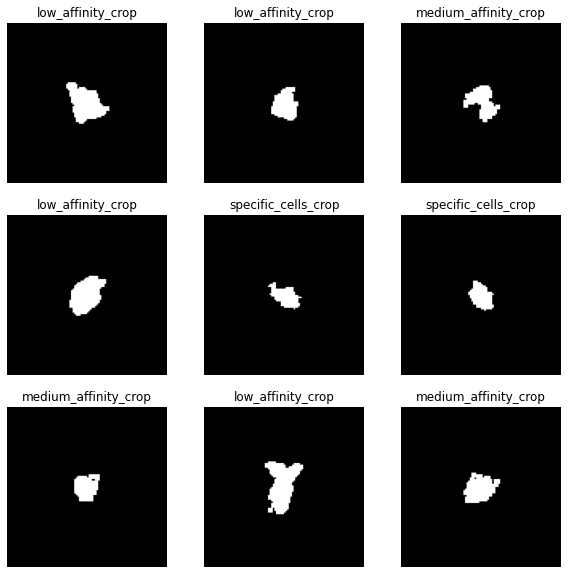

In [ ]:
plot_train_images(train_3, class_names_3)

In [ ]:
normalized_ds_3, image_batch_3, labels_batch_3, first_image_3 = normalize_dataset(train_3)

In [ ]:
train_3, validation_3= cache(train_3, validation_3)

## 3.2. Build model

In [ ]:
logdir='logs' 

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [ ]:
model_3classes = Sequential()  

model_3classes.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(100,100,3))) 
#16 : number of filters; 3,3: filter size; 1:stride; relu
model_3classes.add(MaxPooling2D())
model_3classes.add(Conv2D(32, (3,3), 1, activation='relu'))
model_3classes.add(MaxPooling2D())
model_3classes.add(Dropout(0.2))
model_3classes.add(Conv2D(32, (3,3), 1, activation='relu'))
model_3classes.add(MaxPooling2D())
model_3classes.add(Dropout(0.2))
model_3classes.add(Conv2D(16, (3,3), 1, activation='relu'))
model_3classes.add(Dropout(0.2))
model_3classes.add(MaxPooling2D())
model_3classes.add(Flatten())
model_3classes.add(Dense(100, activation='relu'))
model_3classes.add(Dense(3, activation='softmax'))

model_3classes.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist_3classes = model_3classes.fit(train_3, epochs=20, validation_data=validation_3, callbacks=[tensorboard_callback])

Epoch 1/20
100/100 [==============================] - 127s 1s/step - loss: 2.6260 - accuracy: 0.3707 - val_loss: 1.0744 - val_accuracy: 0.3939
Epoch 2/20
100/100 [==============================] - 33s 327ms/step - loss: 1.1254 - accuracy: 0.4041 - val_loss: 1.0380 - val_accuracy: 0.4632
Epoch 3/20
100/100 [==============================] - 31s 303ms/step - loss: 1.0647 - accuracy: 0.4331 - val_loss: 1.0327 - val_accuracy: 0.4545
Epoch 4/20
100/100 [==============================] - 29s 294ms/step - loss: 1.0427 - accuracy: 0.4473 - val_loss: 1.0142 - val_accuracy: 0.4935
Epoch 5/20
100/100 [==============================] - 30s 296ms/step - loss: 1.0249 - accuracy: 0.4754 - val_loss: 0.9956 - val_accuracy: 0.5325
Epoch 6/20
100/100 [==============================] - 30s 295ms/step - loss: 1.0087 - accuracy: 0.4940 - val_loss: 0.9749 - val_accuracy: 0.5325
Epoch 7/20
100/100 [==============================] - 29s 294ms/step - loss: 0.9838 - accuracy: 0.5091 - val_loss: 0.9247 - val_accu

## 3.3. Evaluate

### 3.3.1 Plot performance

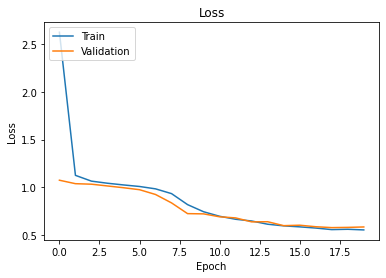

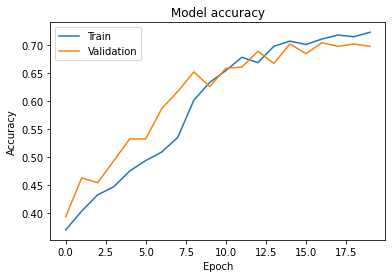

In [ ]:
loss_plot(hist_3classes)
print("")
accuracy_plot(hist_3classes)

### 3.3.2 Evaluate

In [ ]:
get_evaluation_model(test_3, model_3classes)

1/1 [==============================] - 0s 87ms/step


ValueError: ignored

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model_3classes.evaluate(X, y)
    print(f'Test loss: {yhat[0]} / Test accuracy: {yhat[1]}')
    #pre.update_state(y, yhat)
    #re.update_state(y, yhat)
    #acc.update_state(y, yhat)

### 3.3.3 Confusion matrix

1/1 [==============================] - 0s 93ms/step


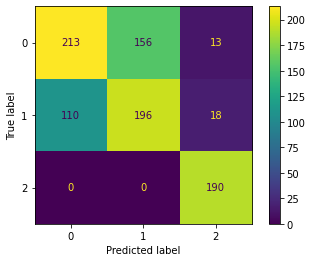

In [ ]:
confusion_matrix_3_classses(test_3, model_3classes)

## 3.5. Save the model

In [ ]:
model_3classes.save('/content/drive/MyDrive/long_project/saved_models/3_classes_model')

# ⏬ Part 4 : Tests on cells from bone marrow film (tumor)

## 4.1. Test tumor films on model 1

Load the model

In [80]:
shape_model = load_model('../content/drive/MyDrive/long_project/saved_models/shape_model')

### 4.1.1 Non-specific

In [104]:
non_spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop'

In [ ]:
os.listdir(non_spe_model_1 )

In [ ]:
ypred = []
name_bad_prediction = []
name_good_prediction = []
for image in os.listdir(non_spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop/{image}')
  preds = shape_model.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())
  if preds.round() == 1:
    name_bad_prediction.append(image)
  else:
    name_good_prediction.append(image)


In [ ]:
ypred

In [108]:
len(name_good_prediction)

405

In [109]:
name_bad_prediction

[]

In [110]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [111]:
len(predicted_labels)

405

In [112]:
correct_labels = np.full((405),0)
len(correct_labels)

405

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 4.1.2. Specific

In [94]:
spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop'

In [ ]:
os.listdir(spe_model_1)

In [ ]:
ypred = []
name_bad_prediction = []
name_good_prediction = []
for image in os.listdir(spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop/{image}')
  preds = shape_model.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())
  if preds.round() == 0:
    name_bad_prediction.append(image)
  else:
    name_good_prediction.append(image)

In [97]:
len(name_bad_prediction)

968

In [100]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [101]:
len(predicted_labels)

968

In [102]:
correct_labels = np.full((968),1)
len(correct_labels)

968

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

## 4.1.3 Test with data augmentation

In [ ]:
non_spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop'

In [ ]:
os.listdir(non_spe_model_1 )

In [ ]:
ypred = []
for image in os.listdir(non_spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop/{image}')
  preds = model.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())
  score = tf.nn.sigmoid(preds[0])
  print(class_names[np.argmax(score)])

In [ ]:
score = tf.nn.sigmoid(preds[0])
class_names[np.argmax(score)]

'non_specific_cells_copy_paste'

In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

405

In [ ]:
correct_labels = np.full((405),0)
len(correct_labels)

405

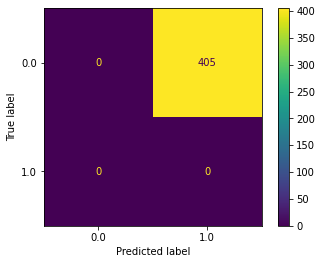

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 5.3.2 Specific

In [ ]:
spe_model_1 = '/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop'

In [ ]:
ypred = []
for image in os.listdir(spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop/{image}')
  preds = model.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())
  score = tf.nn.sigmoid(preds[0])
  print(class_names[np.argmax(score)])


In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

968

In [ ]:
correct_labels = np.full((968),1)
len(correct_labels)

968

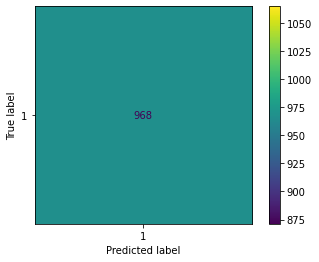

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

## 4.2. Test on 3 classes

Load the model

In [ ]:
model_3classes_load = load_model('/content/drive/MyDrive/long_project/saved_models/3_classes_model')

### 5.2.1 Non-specific

In [ ]:
non_specific_3classes = '/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop'

In [ ]:
non_specific_3_classes_pred = []
for image in os.listdir(non_specific_3classes):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_non_specifique_PB2_crop/{image}')
  preds = model_3classes_load.predict(np.expand_dims(img/255, 0))
  predictions = non_specific_3_classes_pred.append(np.argmax(preds, axis = - 1))


In [ ]:
predicted_labels = tf.concat([item for item in non_specific_3_classes_pred], axis = 0)

In [ ]:
len(predicted_labels)

405

In [ ]:
correct_labels = np.full((405),0)
len(correct_labels)

405

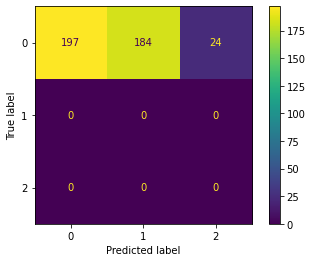

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 4.2.2. Specific

In [ ]:
specific_3classes = '/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop'

In [ ]:
specific_3_classes_pred = []
for image in os.listdir(specific_3classes):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data/Tumor_Ag_specifique_PB2_crop/{image}')
  preds = model_3classes_load.predict(np.expand_dims(img/255, 0))
  predictions = specific_3_classes_pred.append(np.argmax(preds, axis = - 1))
  


In [ ]:
predicted_labels_specific = tf.concat([item for item in specific_3_classes_pred], axis = 0)

In [ ]:
len(predicted_labels_specific)

968

In [ ]:
correct_labels_specific = np.full((968),2)
len(correct_labels_specific)

968

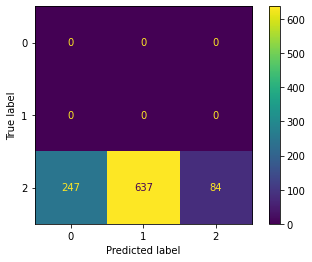

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels_specific, predicted_labels_specific)

## 5.3. Test on Z projection binary classification

Load the model

In [ ]:
z_projection_model1 = load_model('../content/drive/MyDrive/long_project/saved_models/model_time_projection_2_classes')

### 4.1.1 Non-specific

In [ ]:
non_spe_model_1_z_proj = '/content/drive/MyDrive/long_project/tumor_data_z_projection/Tumor_non_specifique_PB2_Z_projected_stack_crop'

In [ ]:
ypred = []
for image in os.listdir(non_spe_model_1_z_proj):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data_z_projection/Tumor_non_specifique_PB2_Z_projected_stack_crop/{image}')
  preds = z_projection_model1.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

461

In [ ]:
correct_labels = np.full((461),0)
len(correct_labels)

461

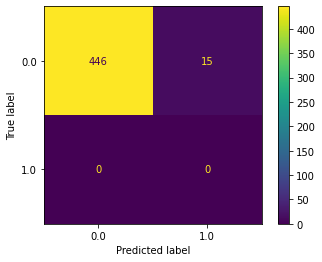

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 4.1.2. Specific

In [ ]:
spe_model_1_z_proj = '/content/drive/MyDrive/long_project/tumor_data_z_projection/Tumor_Ag_specifique_PB2_Z_projected_stack_crop'

In [ ]:
ypred = []
for image in os.listdir(spe_model_1_z_proj):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumor_data_z_projection/Tumor_Ag_specifique_PB2_Z_projected_stack_crop/{image}')
  preds = z_projection_model1.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


In [ ]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [ ]:
len(predicted_labels)

1300

In [ ]:
correct_labels = np.full((1300),1)
len(correct_labels)

1300

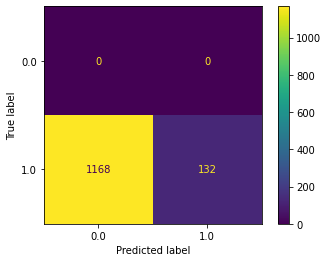

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

## 4.4. Save the model

In [34]:
model_mh_4.save('../content/drive/MyDrive/long_project/saved_models/model_mh_4')

# ⏬ Part 5 : Binary classification (0=low affinity, 1=medium+high afffinity)

## 5.1 Preprocessing

In [16]:
data_dir_4 = "../content/drive/MyDrive/long_project/medium_high_merged"

In [17]:
train_4, test_4, validation_4 = get_train_test_validation_split(data_dir_4, validation_split, seed, img_height, img_width, batch_size)

Found 4528 files belonging to 2 classes.
Using 3170 files for training.
Found 4528 files belonging to 2 classes.
Using 1358 files for validation.


In [18]:
class_names_4= train_4.class_names
print(class_names_4)

['low_affinity_crop', 'medium_high']


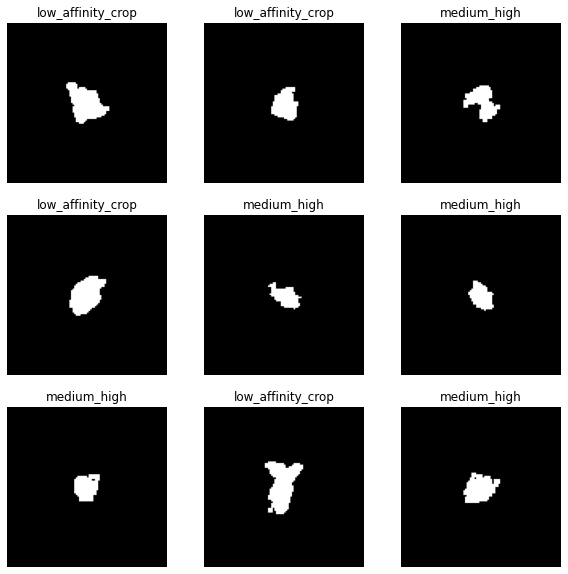

In [19]:
plot_train_images(train_4, class_names_4)

In [20]:
normalized_ds_4, image_batch_4, labels_batch_4, first_image_4 = normalize_dataset(train_4)

In [21]:
train_4, validation_4 = cache(train_4, validation_4)

## 5.2 Build model

In [22]:
logdir='logs' 

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [24]:
num_classes = 2
model_mh_4 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
model_mh_4.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
history_mh_4 = model_mh_4.fit(train_4, validation_data=validation_4,epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
100/100 [==============================] - 329s 3s/step - loss: 0.6194 - accuracy: 0.6801 - val_loss: 0.6234 - val_accuracy: 0.7100
Epoch 2/20
100/100 [==============================] - 17s 172ms/step - loss: 0.5900 - accuracy: 0.7060 - val_loss: 0.6167 - val_accuracy: 0.6840
Epoch 3/20
100/100 [==============================] - 17s 172ms/step - loss: 0.5789 - accuracy: 0.7139 - val_loss: 0.6048 - val_accuracy: 0.6861
Epoch 4/20
100/100 [==============================] - 17s 171ms/step - loss: 0.5693 - accuracy: 0.7183 - val_loss: 0.5980 - val_accuracy: 0.6948
Epoch 5/20
100/100 [==============================] - 17s 172ms/step - loss: 0.5657 - accuracy: 0.7249 - val_loss: 0.6006 - val_accuracy: 0.6797
Epoch 6/20
100/100 [==============================] - 16s 164ms/step - loss: 0.5544 - accuracy: 0.7309 - val_loss: 0.6008 - val_accuracy: 0.6732
Epoch 7/20
100/100 [==============================] - 17s 170ms/step - loss: 0.5471 - accuracy: 0.7353 - val_loss: 0.5998 - val_accu

## 5.3 Evaluate model

### 5.3.1 Plot performance

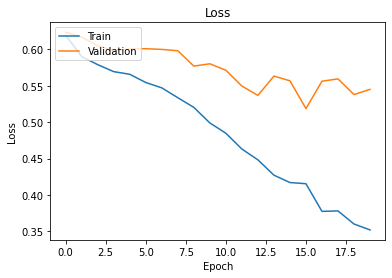

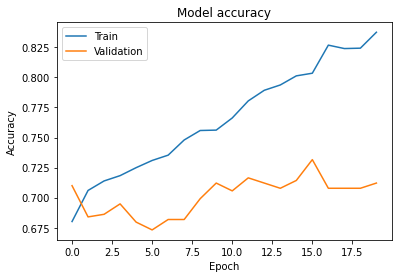

In [29]:
loss_plot(history_mh_4)
print("")
accuracy_plot(history_mh_4)

### 5.3.2 Evaluate

In [31]:
get_evaluation_model(test_4, model_mh_4)

1/1 [==============================] - 0s 62ms/step
Precision: 0.7839850783348083, Recall: 0.7347294688224792, Accuracy: 0.7008928656578064


### 5.3.3 Confusion matrix

1/1 [==============================] - 0s 80ms/step


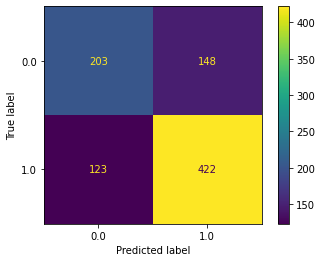

In [32]:
confusion_matrix(test_4, model_mh_4)

### 5.3.4. Classification Report

In [33]:
classif_report(test_4, model_mh_4)

1/1 [==============================] - 0s 62ms/step
              precision    recall  f1-score   support

           0       0.58      0.63      0.60       334
           1       0.77      0.73      0.75       562

    accuracy                           0.69       896
   macro avg       0.67      0.68      0.68       896
weighted avg       0.70      0.69      0.70       896



# ⏬ Part 6. Binary classification with cells edges

## 6.1. Preprocessing

In [35]:
data_dir_6 = "/content/drive/MyDrive/long_project/shape_data_edges"

In [36]:
train_6, test_6, validation_6 = get_train_test_validation_split(data_dir_6, validation_split, seed, img_height, img_width, batch_size)

Found 2733 files belonging to 2 classes.
Using 1914 files for training.
Found 2733 files belonging to 2 classes.
Using 819 files for validation.


In [41]:
class_names_6 = train_6.class_names
print(class_names_6)

['non_specific_cells_find_edges', 'specific_cells_find_edges']


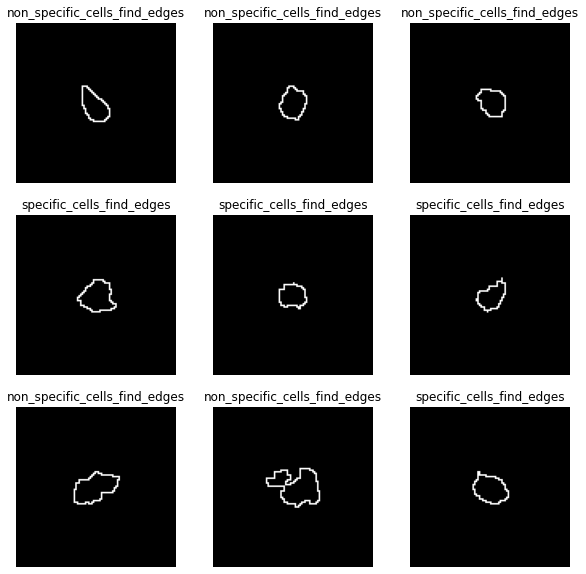

In [42]:
plot_train_images(train_6, class_names_6)

In [43]:
normalized_ds_6, image_batch_6, labels_batch_6, first_image_6 = normalize_dataset(train_6)

In [44]:
train_6, validation_6 = cache(train_6, validation_6)

## 6.2 Model

In [45]:
logdir='logs' 

In [46]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #log model training as training

In [57]:
num_classes = 2
model_edges_4 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [58]:
model_edges_4.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [59]:
history_edges = model_edges_4.fit(train_6, validation_data=validation_6,epochs=15, callbacks=[tensorboard_callback])

Epoch 1/15
60/60 [==============================] - 14s 231ms/step - loss: 0.6593 - accuracy: 0.6014 - val_loss: 0.6303 - val_accuracy: 0.6727
Epoch 2/15
60/60 [==============================] - 15s 248ms/step - loss: 0.6213 - accuracy: 0.6672 - val_loss: 0.6052 - val_accuracy: 0.6618
Epoch 3/15
60/60 [==============================] - 15s 253ms/step - loss: 0.5947 - accuracy: 0.6818 - val_loss: 0.5913 - val_accuracy: 0.6909
Epoch 4/15
60/60 [==============================] - 14s 229ms/step - loss: 0.5766 - accuracy: 0.6933 - val_loss: 0.5819 - val_accuracy: 0.7018
Epoch 5/15
60/60 [==============================] - 16s 263ms/step - loss: 0.5411 - accuracy: 0.7252 - val_loss: 0.5581 - val_accuracy: 0.7200
Epoch 6/15
60/60 [==============================] - 13s 224ms/step - loss: 0.4837 - accuracy: 0.7717 - val_loss: 0.5247 - val_accuracy: 0.7418
Epoch 7/15
60/60 [==============================] - 14s 227ms/step - loss: 0.4209 - accuracy: 0.8103 - val_loss: 0.4550 - val_accuracy: 0.7927

## 6.3 Evaluate model

### 6.3.1 Plot performance

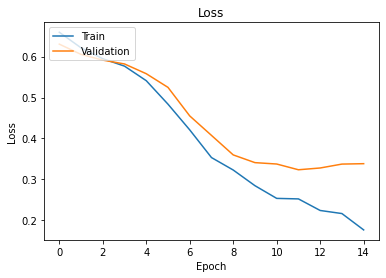

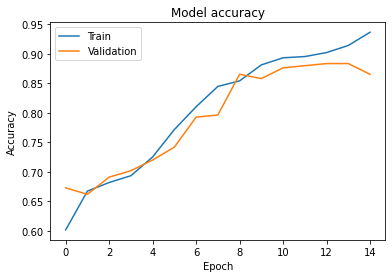

In [60]:
loss_plot(history_edges)
print("")
accuracy_plot(history_edges)

### 6.3.2 Evaluate

In [61]:
get_evaluation_model(test_6, model_edges_4)

1/1 [==============================] - 0s 64ms/step
Precision: 0.7931034564971924, Recall: 0.9504132270812988, Accuracy: 0.8676470518112183


### 6.3.3 Confusion matrix

1/1 [==============================] - 0s 61ms/step


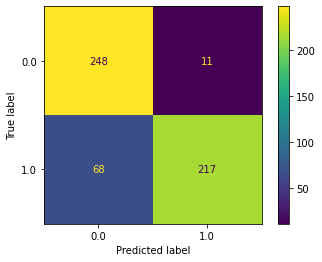

In [62]:
confusion_matrix(test_6, model_edges_4)

### 6.3.4. Classification Report

In [63]:
classif_report(test_6, model_edges_4)

1/1 [==============================] - 0s 68ms/step
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       309
           1       0.79      0.95      0.86       235

    accuracy                           0.87       544
   macro avg       0.87      0.88      0.87       544
weighted avg       0.88      0.87      0.87       544



## 6.4. Save model

In [64]:
model_edges_4.save('../content/drive/MyDrive/long_project/saved_models/model_edges_4')

## 6.5. Test on cells from bone marrow film (tumor)

### 6.5.1. Specific

In [65]:
spe_model_1 = '/content/drive/MyDrive/long_project/tumors_edges_data/Tumor_Ag_specifique_PB2_find_edges'

In [ ]:
ypred = []
for image in os.listdir(spe_model_1):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumors_edges_data/Tumor_Ag_specifique_PB2_find_edges/{image}')
  preds = model_edges_4.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


array([[0.521811]], dtype=float32)

In [67]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [68]:
len(predicted_labels)

946

In [69]:
correct_labels = np.full((946),1)
len(correct_labels)

946

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)

### 6.5.2. Non-specific

In [71]:
non_spe_model = '/content/drive/MyDrive/long_project/tumors_edges_data/Tumor_non_specifique_PB2_find_edges'

In [ ]:
ypred = []
for image in os.listdir(non_spe_model):
  img = cv2.imread(f'/content/drive/MyDrive/long_project/tumors_edges_data/Tumor_non_specifique_PB2_find_edges/{image}')
  preds = model_edges_4.predict(np.expand_dims(img/255, 0))
  ypred.append(preds.round())


In [73]:
predicted_labels = tf.concat([item for item in ypred], axis = 0)

In [74]:
len(predicted_labels)

328

In [75]:
correct_labels = np.full((328),0)
len(correct_labels)

328

In [ ]:
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels)